# Deep Learning porject to classify traffic sign 

# Load Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p' 
testing_file =  './traffic-signs-data/test.p' 

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
import pandas as pd
import numpy as np

n_train = y_train.shape[0]

n_test = y_test.shape[0]

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Data Visualization
* Visualizing the label by selecting one random sample on each label 
* We can verify number that some traffic sign can be meaning same thing after some rotation 
    *  Classes that showing the same sign after horizontal flipping
    [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    *  Classes that showing the same sign after vertical flipping. 
    [1, 5, 12, 15, 17]
    *  Classes that showing the same sign after vertical and horizontal flipping
    [32, 40]
    *  Classes that showing some meaning full sign after horizontal flipping
    [19, 20],[33, 34] ,[36, 37] ,[38, 39],[20, 19] ,[34, 33] ,[37, 36] ,[39, 38]   

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize= (200,200))
    
for num,label_num in enumerate(np.unique(y_train)):
    plt.subplot(6,8,num+ 1)
    plt.imshow(X_train[np.random.choice(np.where(y_train ==label_num)[0],1)][0])
    plt.title('number {} label'.format(label_num))


### Pre-process the Data Set.
* Gray scale the image. Based on previous study Traffic Sign Recognition with Multi-Scale Convolutional Networks by Pierre Sermanet and Yann LeCun on New York univiersity I decided to use grayscale image which show better performance than color images on image classification. 
* Furthermore adding data augmentation to make better performance on model I used Alex Staravoitau's blog(http://navoshta.com/traffic-signs-classification/) as a reference

In [2]:
import cv2
from sklearn.pipeline import make_pipeline,make_union
from sklearn.preprocessing import scale
import numpy as np
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

def grayscale(img_array):
    gray_img = np.empty_like(np.add.reduce(img_array,3))
    for i, x in enumerate(img_array):
        gray_img[i] = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    return gray_img

def equalize_hist(img_array):
    hist_img = np.empty_like(img_array)
    for i, x in enumerate(img_array):
        hist_img[i][:,:,0]  = cv2.equalizeHist(x[:,:,0])
        hist_img[i][:,:,1]  = cv2.equalizeHist(x[:,:,1])
        hist_img[i][:,:,2]  = cv2.equalizeHist(x[:,:,2])

    return hist_img

def processing1(img_array):
    scaled_img = equalize_hist(img_array) 
    scaled_img = grayscale(scaled_img)
    scaled_img = scaled_img.reshape(scaled_img.shape[0],scaled_img.shape[1],scaled_img.shape[2],1)
    scaled_img = scaled_img.astype('float32')
    return scaled_img


def flip_extend(X, y):
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    
    self_flippable_both = np.array([32, 40])
    
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)



In [4]:
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize

X_train = processing1(X_train)
X_valid = processing1(X_valid)
X_test = processing1(X_test)
X_train_extended,y_train_extended=flip_extend(X_train, y_train)
X_train,y_train = shuffle(X_train,y_train)
X_train_extended,y_train_extended = shuffle(X_train_extended,y_train_extended)


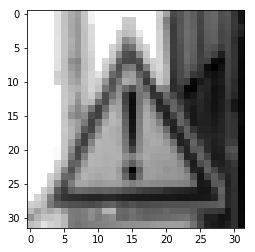

In [16]:
import matplotlib.pylab as plt
%matplotlib inline
plt.imshow(X_train_extended[0].reshape(32,32),cmap='gray')

In [95]:
np.save('X_train_extended',X_train_extended)
np.save('y_train_extended',y_train_extended)
np.save('X_valid',X_valid)
np.save('y_valid',y_valid)

In [3]:
import numpy as np

X_train_extended = np.load('./X_train_extended.npy')
y_train_extended = np.load('./y_train_extended.npy')
X_valid = np.load('./X_valid.npy')
y_valid = np.load('./y_valid.npy')

### Model Architecture
* In the first Model I created the model considering Lenet Structure which has no drop-out stage
* In the first model we can see overfitting tendancy during first 10 epoches.
* I choose to use AdagradOptimzer which might be better choice to compare first 10 epoches

In [4]:
import tensorflow as tf


EPOCHS = 10
BATCH_SIZE = 128

weights = {'wc1': tf.Variable(tf.truncated_normal(shape = (5,5,1,6), mean = 0,stddev = 0.1)),
          'wc2': tf.Variable(tf.truncated_normal(shape = (5,5,6,16), mean = 0,stddev = 0.1)),
          'wd1': tf.Variable(tf.truncated_normal(shape = (400,120), mean = 0,stddev = 0.1)),
          'wd2': tf.Variable(tf.truncated_normal(shape = (120,84), mean = 0,stddev = 0.1)),
          'wd3': tf.Variable(tf.truncated_normal( shape = (84,43), mean = 0,stddev = 0.1)),
          'wc1_gamma': tf.Variable(tf.truncated_normal(shape = (3,3,6,32), mean = 0 ,stddev= 0.1)),
          'wc2_beta' : tf.Variable(tf.truncated_normal(shape = (1,1,16,32) ,mean = 0 ,stddev= 0.1)),
          'bd_flat': tf.Variable(tf.truncated_normal(shape = (1600,120),mean = 0, stddev = 0.1 ))}

biases = { 'bc1' : tf.Variable(tf.random_normal([6])),
           'bc2' : tf.Variable(tf.random_normal([16])),
         'bd1' : tf.Variable(tf.random_normal([120])),
         'bd2' : tf.Variable(tf.random_normal([84])),
         'bd3' : tf.Variable(tf.random_normal([43])),
         'wc1_gamma': tf.Variable(tf.random_normal([32])),
         'wc2_beta' : tf.Variable(tf.random_normal([32]))}

def batch_norm_layer(x, train_phase):
    bn_train = tf.contrib.layers.batch_norm(x, center=True, scale=True, is_training=True)
    bn_inference = tf.contrib.layers.batch_norm(x, center=True, scale=True, is_training=False)
    bn = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
    return bn

def drop_out_layer(x,train_phase,keep_prob):
    dropout_train = tf.nn.dropout(x,keep_prob)
    return tf.cond(train_phase, lambda : dropout_train, lambda: x)

def cnl_layer(x,conv_W,bias_weight,training_phase,batch_norm = False,activation = 1):
    mu = 0
    sigma = 0.1
    cnl    = tf.nn.bias_add(tf.nn.conv2d(x,conv_W, strides=[1, 1, 1, 1], padding='VALID'),bias_weight) 
    if batch_norm :
        cnl = batch_norm_layer(cnl,training_phase)
    # RELU for Activation.
    if activation == 1: 
        cnl = tf.nn.relu(cnl)
    
    return cnl
def pooled_convlayer(x,conv_W,bias_weight,training_phase,batch_norm =False,drop_out =False,
                    keep_prob = 0.6):
    mu = 0
    sigma = 0.1
    cnl    = tf.nn.bias_add(tf.nn.conv2d(x,conv_W, strides=[1, 1, 1, 1], padding='VALID'),bias_weight) 
    if batch_norm: 
        cnl = batch_norm_layer(cnl,training_phase)
        
    # RELU for Activation.
    cnl = tf.nn.relu(cnl)
    if drop_out:
        cnl = drop_out_layer(cnl,training_phase, keep_prob)
    #Pooling
    cnl = tf.nn.max_pool(cnl, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    return cnl

def full_connection_layer(x,fully_W, bias_weight,activation = 1, drop_out = False,training_phase= True,keep_prob = 0.6):
    mu = 0
    sigma = 0.1
    fc   = tf.nn.bias_add(tf.matmul(x, fully_W) ,bias_weight)
    
    # RELU for Activation.
    if activation == 1 :
        fc = tf.nn.relu(fc)
        if drop_out == True:
            fc = drop_out_layer(fc,training_phase,keep_prob)
    return fc
def Lenet(x,is_training):
    # Layer 1. Convolutional. Input = 32x32x1. Output = 14x14x6
    cnv_layer_1 = pooled_convlayer(x,weights['wc1'],biases['bc1'],is_training)
    # Layer 2 Convolutional. Input = 14x14x6. Output = 5x5x16
    cnv_layer_2 = pooled_convlayer(cnv_layer_1, weights['wc2'],biases['bc2'],is_training)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc_1 = tf.contrib.layers.flatten(cnv_layer_2)
    fc_1 = full_connection_layer(fc_1,weights['wd1'],biases['bd1'])
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2 = full_connection_layer(fc_1,weights['wd2'],biases['bd2'])
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3 = full_connection_layer(fc_2,weights['wd3'],biases['bd3'],activation=0)
    return fc_3

In [5]:

rate = 0.001
x = tf.placeholder(tf.float32, (None, 32, 32, 1),name='x')
y = tf.placeholder(tf.int32, (None),name = 'y')
one_hot_y  = tf.one_hot(y,43)
is_training = tf.placeholder(tf.bool) 
logits = Lenet(x,is_training)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(learning_rate = rate) 
training_operation = optimizer.minimize(loss_operation)

In [8]:
import tensorflow as tf
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data,training):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,is_training:training})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)

    print("Training...")
    print()
    for i in range(10):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)    
        validation_accuracy = evaluate(X_valid, y_valid,False)
        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Training Accuracy  = {:.3f}".format(training_accuracy))
        print()

    saver.save(sess, './lenet1/lenet1.ckpt')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.255 Training Accuracy  = 0.370

EPOCH 2 ...
Validation Accuracy = 0.326 Training Accuracy  = 0.462

EPOCH 3 ...
Validation Accuracy = 0.387 Training Accuracy  = 0.520

EPOCH 4 ...
Validation Accuracy = 0.424 Training Accuracy  = 0.563

EPOCH 5 ...
Validation Accuracy = 0.460 Training Accuracy  = 0.597

EPOCH 6 ...
Validation Accuracy = 0.487 Training Accuracy  = 0.624

EPOCH 7 ...
Validation Accuracy = 0.512 Training Accuracy  = 0.645

EPOCH 8 ...
Validation Accuracy = 0.529 Training Accuracy  = 0.664

EPOCH 9 ...
Validation Accuracy = 0.544 Training Accuracy  = 0.680

EPOCH 10 ...
Validation Accuracy = 0.561 Training Accuracy  = 0.695

Model saved


* To handel overfitting problem on Lenet1 Structure drop-out stage was added. 
* Also add batch_normal layer to increase performance of the model 

In [96]:

def Lenet2(x, is_training):
    # Layer 1. Convolutional. Input = 32x32x1. Output = 14x14x6
    cnv_layer_1 = pooled_convlayer(x,weights['wc1'],biases['bc1'],batch_norm = True,drop_out = True
                                   ,training_phase = is_training)
    # Layer 2 Convolutional. Input = 14x14x6. Output = 5x5x16
    cnv_layer_2 = pooled_convlayer(cnv_layer_1, weights['wc2'],biases['bc2'],batch_norm = True,drop_out = True
                                   ,training_phase =  is_training)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc_1 = tf.contrib.layers.flatten(cnv_layer_2)
    fc_1 = full_connection_layer(fc_1,weights['wd1'],biases['bd1'],drop_out =False,training_phase = is_training)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2 = full_connection_layer(fc_1,weights['wd2'],biases['bd2'],drop_out =False,training_phase = is_training)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3 = full_connection_layer(fc_2,weights['wd3'],biases['bd3'],activation=0)
    return fc_3


is_training = tf.placeholder(tf.bool) 
logits = Lenet2(x,is_training)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [97]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)

    print("Training...")
    print()
    for i in range(10):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training : True})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)    
        validation_accuracy = evaluate(X_valid, y_valid,False)
        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Training Accuracy  = {:.3f}".format(training_accuracy))
        print()

    saver.save(sess, './lenet2/lenet2.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.107 Training Accuracy  = 0.288

EPOCH 2 ...
Validation Accuracy = 0.188 Training Accuracy  = 0.387

EPOCH 3 ...
Validation Accuracy = 0.214 Training Accuracy  = 0.460

EPOCH 4 ...
Validation Accuracy = 0.236 Training Accuracy  = 0.510

EPOCH 5 ...
Validation Accuracy = 0.256 Training Accuracy  = 0.547

EPOCH 6 ...
Validation Accuracy = 0.275 Training Accuracy  = 0.573

EPOCH 7 ...
Validation Accuracy = 0.293 Training Accuracy  = 0.595

EPOCH 8 ...
Validation Accuracy = 0.311 Training Accuracy  = 0.613

EPOCH 9 ...
Validation Accuracy = 0.333 Training Accuracy  = 0.629

EPOCH 10 ...
Validation Accuracy = 0.347 Training Accuracy  = 0.643

Model saved


* Since the model improve it's performance we try to remove batch_normalization field and add drop out layer in the fully connected layers 

In [6]:
#tf.reset_default_graph()

def Lenet3(x, is_training):
    # Layer 1. Convolutional. Input = 32x32x1. Output = 14x14x6
    cnv_layer_1 = pooled_convlayer(x,weights['wc1'],biases['bc1'],training_phase =  is_training)
    # Layer 2 Convolutional. Input = 14x14x6. Output = 5x5x16
    cnv_layer_2 = pooled_convlayer(cnv_layer_1, weights['wc2'],biases['bc2'], training_phase = is_training)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc_1 = tf.contrib.layers.flatten(cnv_layer_2)
    fc_1 = full_connection_layer(fc_1,weights['wd1'],biases['bd1'],drop_out = True, training_phase = is_training)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2 = full_connection_layer(fc_1,weights['wd2'],biases['bd2'], drop_out = True, training_phase = is_training)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3 = full_connection_layer(fc_2,weights['wd3'],biases['bd3'],activation=0)
    return fc_3
    return logits
is_training = tf.placeholder(tf.bool) 
logits = Lenet3(x,is_training)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)
    print("Training...")
    print()
    for i in range(3):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training : True})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)    
        validation_accuracy = evaluate(X_valid, y_valid,False)
        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Training Accuracy  = {:.3f}".format(training_accuracy))
        print()
    
    saver.save(sess, './lenet3/lenet3')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.076 Training Accuracy  = 0.092

EPOCH 2 ...
Validation Accuracy = 0.086 Training Accuracy  = 0.118

EPOCH 3 ...
Validation Accuracy = 0.101 Training Accuracy  = 0.138

Model saved


* In the fourth model drop-out layer was place only right after input layer

In [84]:
def Lenet4(x, is_training):
    x = tf.nn.dropout(x,0.6)
    # Layer 1. Convolutional. Input = 32x32x1. Output = 14x14x6
    cnv_layer_1 = pooled_convlayer(x,weights['wc1'],biases['bc1'],batch_norm = True,drop_out = False,training_phase =  is_training)
    # Layer 2 Convolutional. Input = 14x14x6. Output = 5x5x16
    cnv_layer_2 = pooled_convlayer(cnv_layer_1, weights['wc2'],biases['bc2'], batch_norm = True,drop_out = False,training_phase = is_training)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc_1 = tf.contrib.layers.flatten(cnv_layer_2)
    fc_1 = full_connection_layer(fc_1,weights['wd1'],biases['bd1'])
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2 = full_connection_layer(fc_1,weights['wd2'],biases['bd2'])
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3 = full_connection_layer(fc_2,weights['wd3'],biases['bd3'],activation=0)
    return fc_3
    return logits
is_training = tf.placeholder(tf.bool) 
logits = Lenet4(x,is_training)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [89]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Training...")
    print()
    for i in range(10):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training : True})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)    
        validation_accuracy = evaluate(X_valid, y_valid,False)
        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Traing Accuracy  = {:.3f}".format(training_accuracy))
        print()

    saver.save(sess, './lenet4/lenet4')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.048 Traing Accuracy  = 0.172

EPOCH 2 ...
Validation Accuracy = 0.063 Traing Accuracy  = 0.230

EPOCH 3 ...
Validation Accuracy = 0.073 Traing Accuracy  = 0.279

EPOCH 4 ...
Validation Accuracy = 0.083 Traing Accuracy  = 0.332

EPOCH 5 ...
Validation Accuracy = 0.092 Traing Accuracy  = 0.374

EPOCH 6 ...
Validation Accuracy = 0.096 Traing Accuracy  = 0.409

EPOCH 7 ...
Validation Accuracy = 0.106 Traing Accuracy  = 0.439

EPOCH 8 ...
Validation Accuracy = 0.113 Traing Accuracy  = 0.465

EPOCH 9 ...
Validation Accuracy = 0.121 Traing Accuracy  = 0.484

EPOCH 10 ...
Validation Accuracy = 0.131 Traing Accuracy  = 0.501

Model saved


* In the fifth model try to implement inception layer which use the different kind of convolutional layer all at once

* We can find that inception laeyr suddenly stuck into local optimum

In [35]:
map1 = 6
num_fc1 = 84
num_fc2 = 43
reduce1x1 = 12
dropout=0.5

inception_weights = {'incept_1_1': tf.Variable(tf.truncated_normal(shape = (1,1,6,map1), mean = 0,stddev = 0.1)),
          'incept_1_2': tf.Variable(tf.truncated_normal(shape = (1,1,6,reduce1x1), mean = 0,stddev = 0.1)),
          'incept_1_3':  tf.Variable(tf.truncated_normal(shape = (1,1,6,reduce1x1), mean = 0,stddev = 0.1)),
          'incept_3':  tf.Variable(tf.truncated_normal(shape = (3,3,reduce1x1,map1), mean = 0,stddev = 0.1)),
          'incept_5': tf.Variable(tf.truncated_normal(shape = (5,5,reduce1x1,map1), mean = 0,stddev = 0.1)),
          'incept_1_4' : tf.Variable(tf.truncated_normal(shape = (1,1,6,map1), mean = 0,stddev = 0.1)),
          'wc2' : tf.Variable(tf.truncated_normal(shape = (5,5,24,16), mean = 0,stddev = 0.1)),
          'fc1': tf.Variable(tf.truncated_normal(shape = (2304,120),mean = 0, stddev = 0.1 )),
          'fc2': tf.Variable(tf.truncated_normal(shape = (num_fc1,num_fc2),mean = 0, stddev = 0.1 ))}



inception_biases = { 'bias_1' : tf.Variable(tf.random_normal([reduce1x1])),
                     'bias_2' : tf.Variable(tf.random_normal([map1])),
                   'bias_3' : tf.Variable(tf.random_normal([map2])),
                   'bias_4' : tf.Variable(tf.random_normal([num_fc1])),
                   'bias_5' : tf.Variable(tf.random_normal([num_fc2]))}


def conv2d_s1(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_3x3_s1(x):
    return tf.nn.max_pool(x,ksize=[1,3,3,1],
                         strides=[1,1,1,1],padding='SAME')


def inception(x,train):
    cnv_layer_1 = cnl_layer(x,weights['wc1'],biases['bc1'],batch_norm = False,training_phase =  is_training,activation = 0)

    #Inception Module 1
    conv1_1x1_1 = conv2d_s1(cnv_layer_1,inception_weights['incept_1_1']) + inception_biases['bias_2']
    conv1_1x1_2 = tf.nn.relu(conv2d_s1(cnv_layer_1, inception_weights['incept_1_2']) + inception_biases['bias_1'])
    conv1_1x1_3 = tf.nn.relu(conv2d_s1(cnv_layer_1, inception_weights['incept_1_3']) + inception_biases['bias_1'])
    conv1_3x3 = conv2d_s1(conv1_1x1_2,inception_weights['incept_3']) + inception_biases['bias_2']
    conv1_5x5 = conv2d_s1(conv1_1x1_3,inception_weights['incept_5']) + inception_biases['bias_2']
    maxpool1 = max_pool_3x3_s1(cnv_layer_1)
    conv1_1x1_4 = conv2d_s1(maxpool1, inception_weights['incept_1_4']) + inception_biases['bias_2']
    
    #concatenate all the feature maps and hit them with a relu
    inception1 = tf.nn.relu(tf.concat([conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4], axis = 3))
    
    cnv_layer_2 = pooled_convlayer(inception1,inception_weights['wc2'],biases['bc2'],
                                   batch_norm = False,training_phase =  is_training)
    # conv2 = 
    #flatten features for fully connected layer
    fc_1 = tf.contrib.layers.flatten(cnv_layer_2)
    fc_1 = full_connection_layer(fc_1,inception_weights['fc1'],biases['bd1'])
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2 = full_connection_layer(fc_1,weights['wd2'],biases['bd2'])
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3 = full_connection_layer(fc_2,weights['wd3'],biases['bd3'],activation=0)
    #Fully connected layers
    return fc_3





is_training = tf.placeholder(tf.bool) 
logits = inception(x,is_training)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [37]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)

    print("Training...")
    print()
    for i in range(5):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training : True})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)    
        validation_accuracy = evaluate(X_valid, y_valid,False)
        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Training Accuracy  = {:.3f}".format(training_accuracy))
        print()

    saver.save(sess, './inception/inception.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.206 Traing Accuracy  = 0.319

EPOCH 2 ...
Validation Accuracy = 0.295 Traing Accuracy  = 0.434

EPOCH 3 ...
Validation Accuracy = 0.364 Traing Accuracy  = 0.502

EPOCH 4 ...
Validation Accuracy = 0.419 Traing Accuracy  = 0.555

EPOCH 5 ...
Validation Accuracy = 0.463 Traing Accuracy  = 0.596

Model saved


* In the last model I used slim layer on the tensorflow to easily applying batch normalization
* Also re define evaluate function to apply drop out layer only on training data set

In [12]:
import tensorflow as tf
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def summary_evaluate(X_data, y_data,training,writer):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        summary,accuracy = sess.run([merged,accuracy_operation], feed_dict={x: batch_x, y: batch_y,is_training:training})
        total_accuracy += (accuracy * len(batch_x))
        writer.add_summary(summary,i )
    return total_accuracy / num_examples


# Merge all the summaries and write them out to /tmp/mnist_logs (by default)


In [10]:
import tensorflow.contrib.slim as slim  # TensorFlow-Slim
import tensorflow as tf
tf.reset_default_graph()

def Lenet5(x,is_training):
    
    with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
        

        net1 = slim.conv2d(x, 6, [5, 5], scope='conv0',padding = 'VALID')  #5 x5 convolutional filter
        net1 = slim.max_pool2d(net1, [2, 2],stride =2,padding='VALID', scope='pool0')  
        net2 = slim.conv2d(net1, 16, [5, 5], padding='VALID', scope='conv2')  
        net2 = slim.max_pool2d(net2, [2, 2], 2,padding = 'VALID', scope='pool1') 
        
        net1_beta = slim.max_pool2d(net1, [2, 2],2,padding ='VALID', scope='conv1_beta')  
        net1_gamma = slim.conv2d(net1_beta, 32, [3, 3],padding='VALID', scope='conv1_gamma',activation_fn =None)  
        
        net2_beta = slim.conv2d(net2,32, [1,1],padding='SAME', scope='conv2b',activation_fn = None) 
        new_conv = tf.concat([net1_gamma,net2_beta],1)

        new_conv = tf.contrib.layers.flatten(new_conv)

        fc_1 = slim.fully_connected(new_conv,120, scope = 'fc1')
        fc_1 = drop_out_layer(fc_1,is_training, 0.5)

        # Final fully-connected layers
        fc_2 = slim.fully_connected(fc_1, 84, scope='fc4')
        fc_2 = drop_out_layer(fc_2, is_training ,0.5)

        fc_3 = slim.fully_connected(fc_2, 43, scope='fc6',activation_fn = None)
        return fc_3


rate =0.001  # learning rate

x = tf.placeholder(tf.float32, (None, 32, 32, 1),name='x')
y = tf.placeholder(tf.int32, (None),name = 'y')
one_hot_y  = tf.one_hot(y,43)

is_training = tf.placeholder(tf.bool) 
logits = Lenet5(x,is_training)
tf.summary.histogram('logits',logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = one_hot_y)
tf.summary.histogram('cross_entropy',cross_entropy)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(rate) 
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
merged = tf.summary.merge_all()
saver = tf.train.Saver()




In [99]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_extended)
    print("Training...")
    for i in range(10):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_training: True})

        training_accuracy = evaluate(X_train_extended,y_train_extended,True)

        validation_accuracy = evaluate(X_valid, y_valid,False)

        print("EPOCH {} ...".format(i+1))

        print("Validation Accuracy = {:.3f}".format(validation_accuracy),
              "Training Accuracy  = {:.3f}".format(training_accuracy))
        print()

    saver.save(sess, './lenet5/lenet5')
    print("Model saved")


Training...
EPOCH 1 ...
Validation Accuracy = 0.327 Training Accuracy  = 0.285

EPOCH 2 ...
Validation Accuracy = 0.398 Training Accuracy  = 0.385

EPOCH 3 ...
Validation Accuracy = 0.447 Training Accuracy  = 0.437

EPOCH 4 ...
Validation Accuracy = 0.472 Training Accuracy  = 0.470

EPOCH 5 ...
Validation Accuracy = 0.498 Training Accuracy  = 0.500

EPOCH 6 ...
Validation Accuracy = 0.530 Training Accuracy  = 0.520

EPOCH 7 ...
Validation Accuracy = 0.548 Training Accuracy  = 0.538

EPOCH 8 ...
Validation Accuracy = 0.561 Training Accuracy  = 0.552

EPOCH 9 ...
Validation Accuracy = 0.580 Training Accuracy  = 0.566

EPOCH 10 ...
Validation Accuracy = 0.599 Training Accuracy  = 0.578

Model saved


* Since the Lenet 5 model(model implemented batch normalization with slim) show us the best performance we choose Lenet 5 model as our final model

In [13]:
#sv = tf.train.Supervisor(logdir="/lenet5/")
with tf.Session() as sess:  
    saver.restore(sess, tf.train.latest_checkpoint('./lenet5/'))
    train_writer = tf.summary.FileWriter('./train',
                                      sess.graph)
    test_writer = tf.summary.FileWriter('./test',sess.graph)

    
    num_examples = len(X_train_extended)
    print("Training...")
    for i in range(1):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_extended[offset:end], y_train_extended[offset:end]
            sess.run(training_operation,feed_dict = {x: batch_x,y: batch_y,is_training:True})
        if i %1 == 0 : 
            training_accuracy = summary_evaluate(X_train_extended,y_train_extended,True,train_writer)
            tf.summary.scalar('training_accuracy',training_accuracy)
            validation_accuracy = summary_evaluate(X_valid, y_valid,False,test_writer)
            tf.summary.scalar('validation_accuracy', validation_accuracy)

            print("EPOCH {} ...".format(i+1+ 820))

            print("Validation Accuracy = {:.3f}".format(validation_accuracy),
                  "Training Accuracy  = {:.3f}".format(training_accuracy))
            print() 

    saver.save(sess, './lenet5/lenet5')
    print("Model saved")
    

Training...
EPOCH 821 ...
Validation Accuracy = 0.930 Training Accuracy  = 0.942

Model saved


* Calcualte Test Accuracy

In [20]:
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('./lenet5/'))
    
    test_accuracy = evaluate(X_test,y_test,False)
    validation_accuracy = evaluate(X_valid,y_valid,False)
    
    print( "Test Accuracy = {:.3f}".format(test_accuracy),'\n',
           "Validation Accuracy = {:.3f}".format(validation_accuracy))

Test Accuracy = 0.929 
 Validation Accuracy = 0.930


### Testing model on new images
* I used georgesung's github [repository](https://github.com/georgesung/traffic_sign_classification_german) as a reference

In [22]:
import os 
from PIL import Image

image_files  = ['sample_images/' + image_file for image_file in os.listdir('sample_images')]
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((32, 32), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')



* Visualize Images
* We can verify that our newly selected image have more clear background than the other images. 
* image circulate.png and km_60.png contain getty images banner so it hide some part of their original sign 

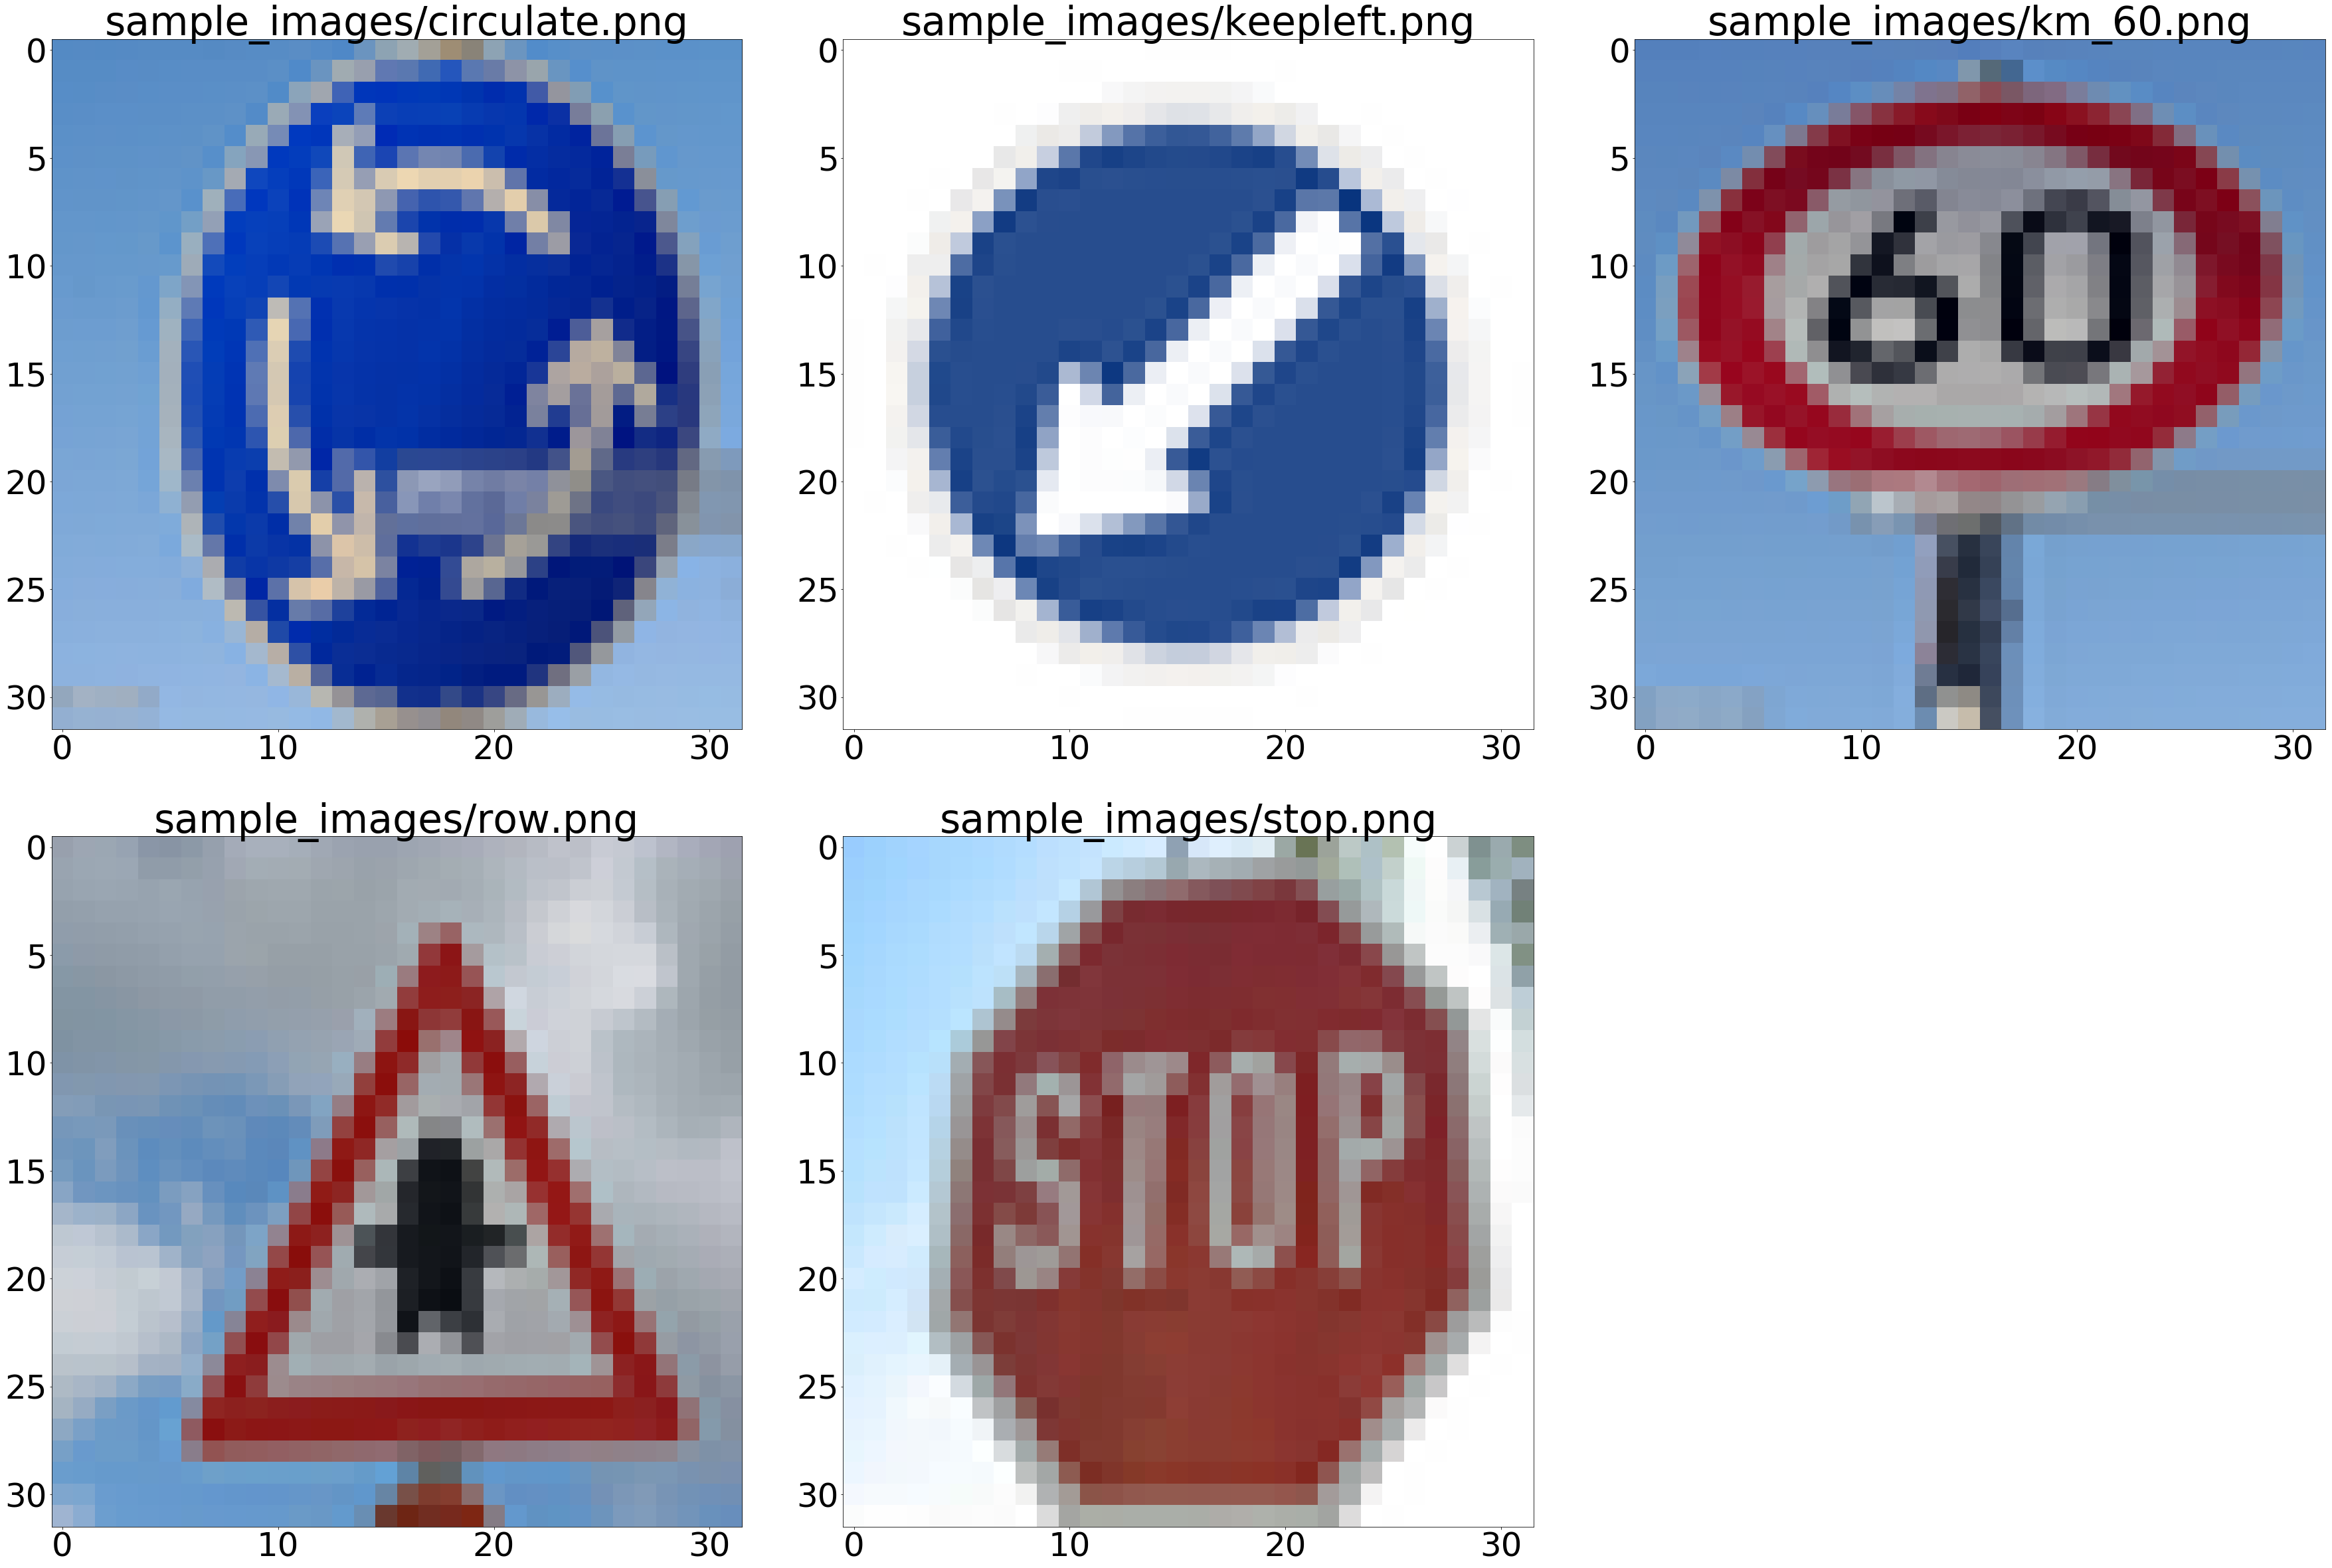

In [23]:
import matplotlib.pylab as plt 
import matplotlib as mpl
plt.figure(figsize= (50,50))
mpl.rcParams.update({'font.size': 50})

# Visually inspect sample images
for i, image in enumerate(images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(image_files[i])

plt.tight_layout()
plt.show()
images = processing1(images)


* Load model's label in label_map

In [24]:
# Load signnames.csv to map label number to sign string
label_map = {}
with open('signnames.csv', 'r') as f:
    first_line = True
    for line in f:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [25]:

# GET expect result from model 
predictions = tf.argmax(logits, 1)


with  tf.Session() as sess:
    #restore model and calculate
    saver.restore(sess, tf.train.latest_checkpoint('./lenet5/'))
    logit, predict = sess.run([logits, predictions], feed_dict={x: images, is_training: False})


final_preds = [label_map[pred] for pred in predict]



 * Final Prediction of image


In [26]:

# Print predictions on my sample images
print('Predictions on sample images\n')
for i in range(len(images)):
    print('%s --> %s' % (image_files[i], final_preds[i]))


Predictions on sample images

sample_images/circulate.png --> Speed limit (30km/h)

sample_images/keepleft.png --> Keep left

sample_images/km_60.png --> No entry

sample_images/row.png --> Right-of-way at the next intersection

sample_images/stop.png --> Stop



* Get top k score from model on test dataset

In [27]:

# Use TensorFlow's softmax and top_k functions
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('./lenet5/'))
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={logits: logit})
    
    

def pred_certainty_str(top_k_val, top_k_idx):
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]
    
    pcs = ''
    for i in range(5):
        pcs += '%s: %.2f%%\n' % (top_k_pred[i].replace('\n', ''), top_k_val[i] * 100)
        
    return pcs

* We can verify that our model classify keep left image, Right of way at the next intersection image and stop image
* My model give wrong answer on RoundaboutMandatory image but it also consider it with high probability
* Our model is completly wrong on the speed 60 km/h limit sign. It give strong confidence that this image is No entry image

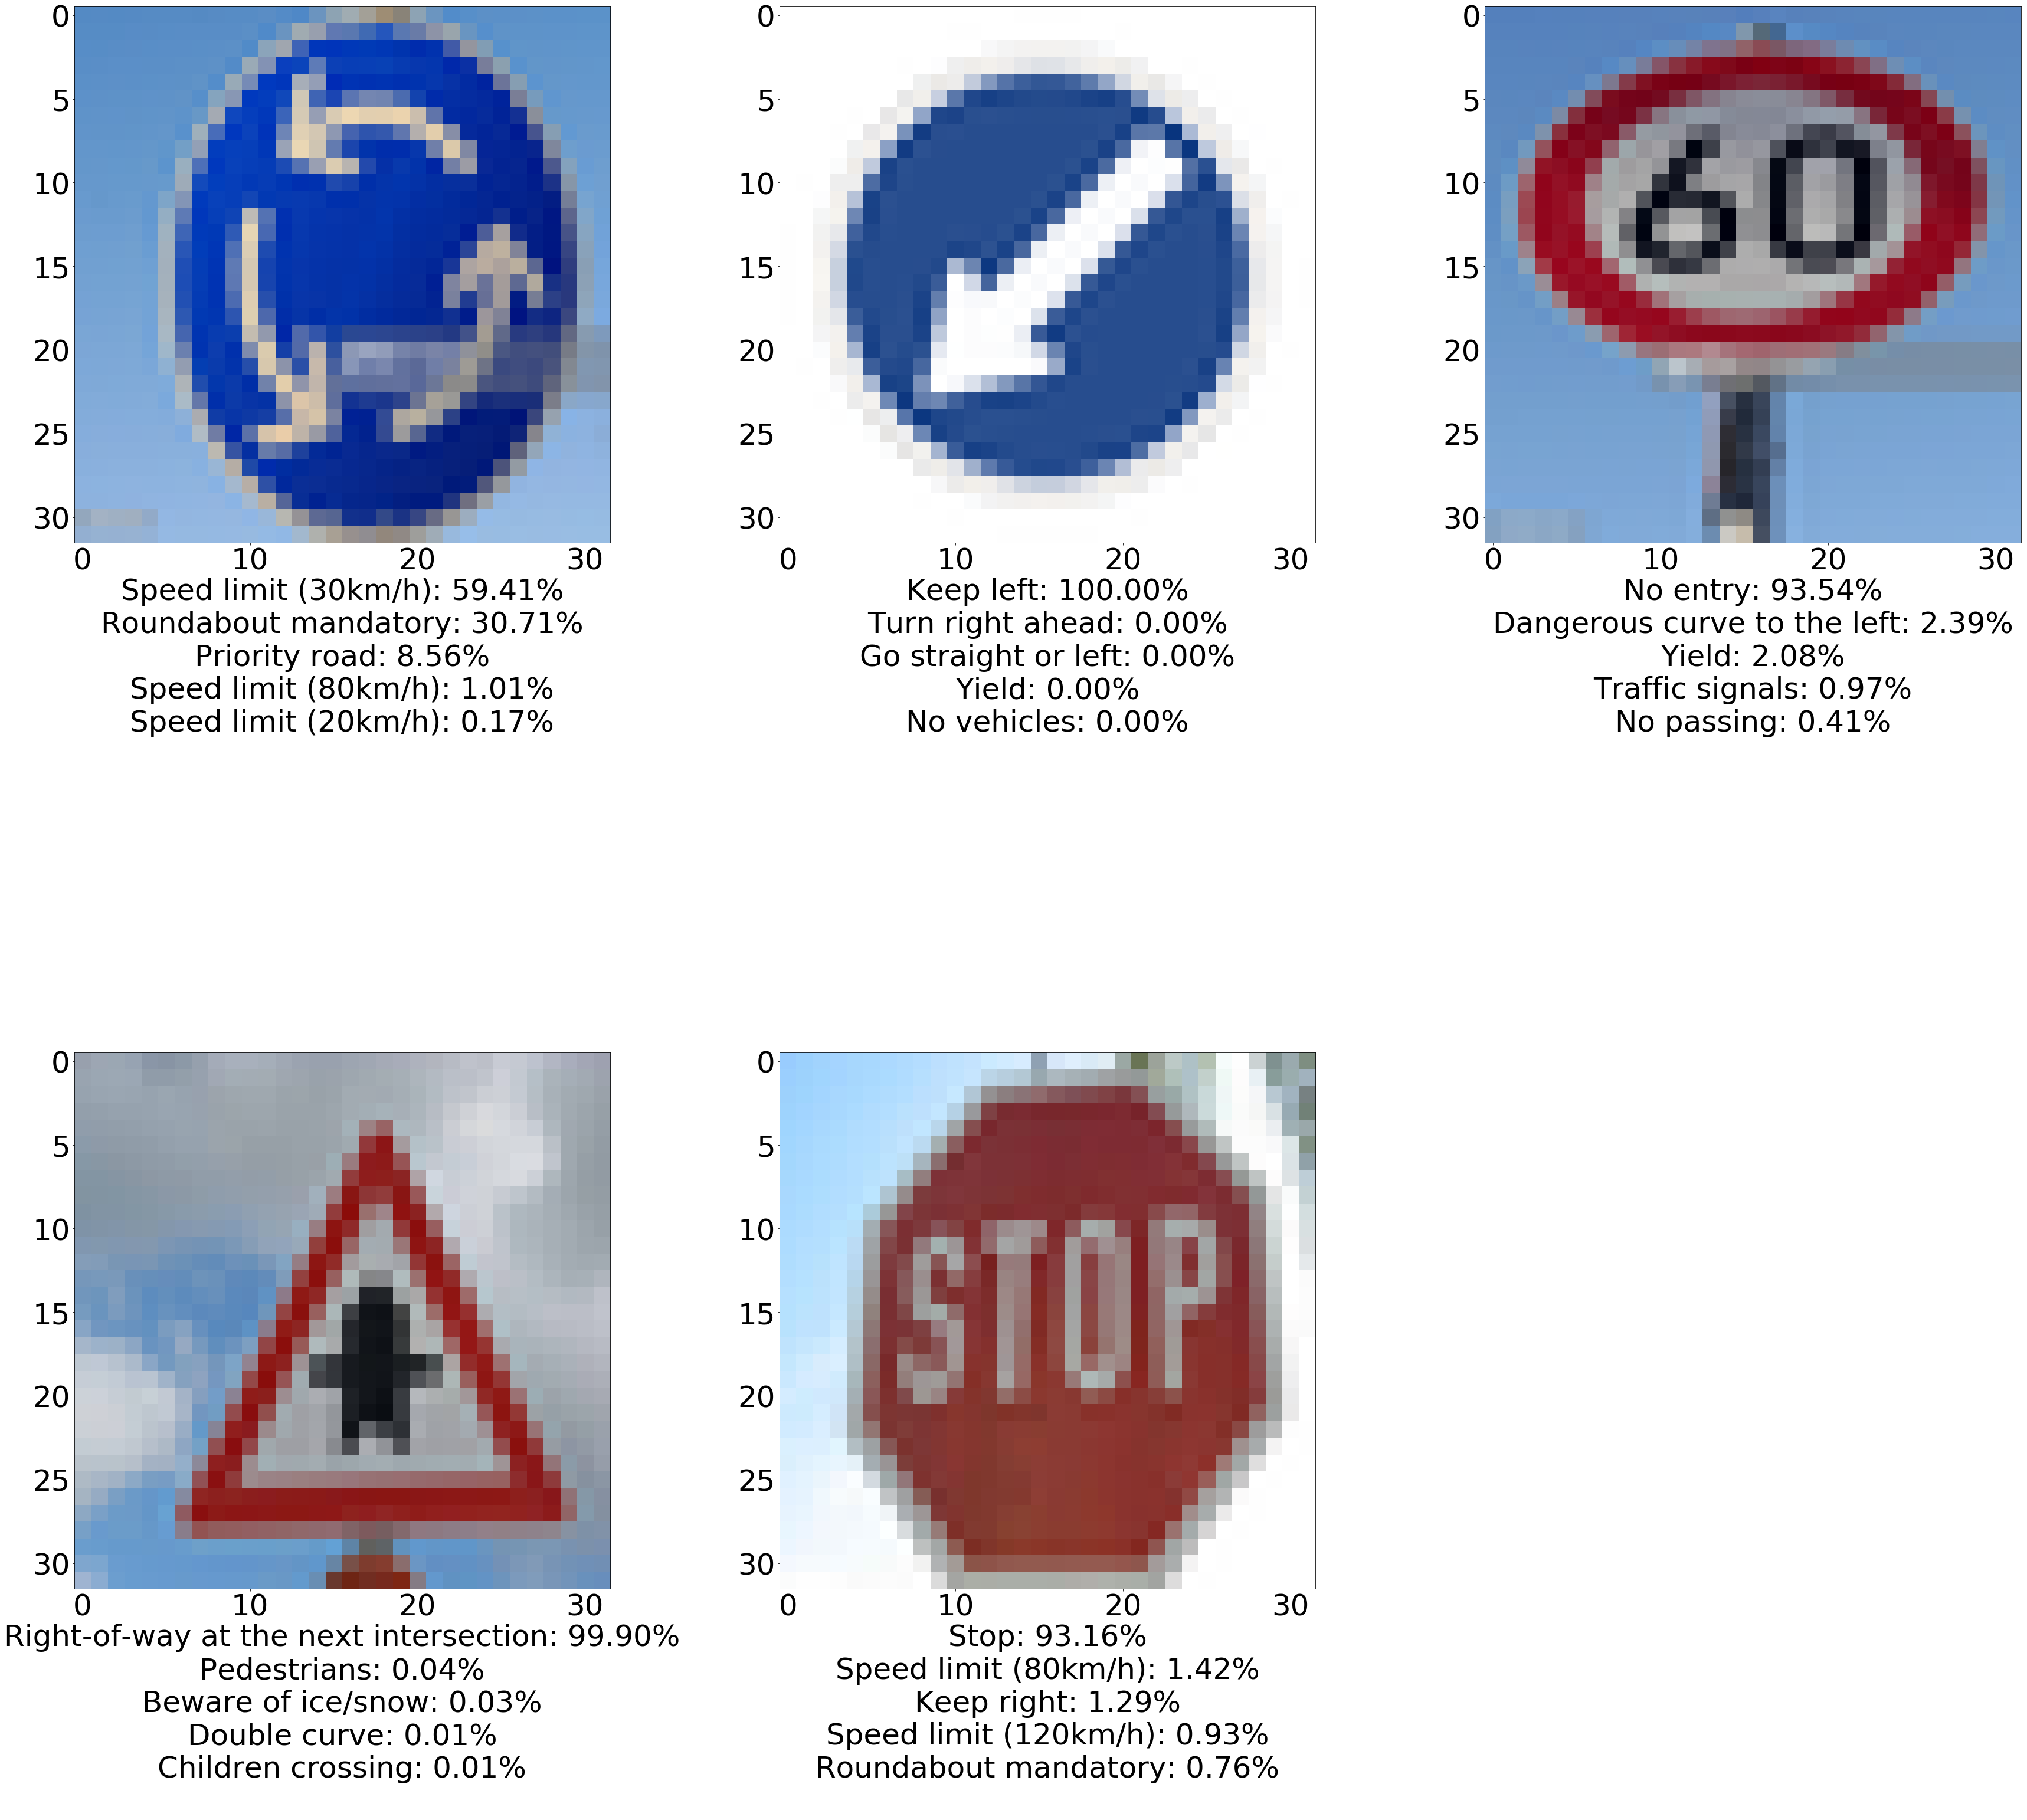

In [28]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline
plt.figure(figsize= (50,50))
mpl.rcParams.update({'font.size': 50})

#Reload original test data_sets
images = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((32, 32), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))

    images.append(image)
images = np.array(images, dtype='uint8')

for i, image in enumerate(images):
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.xlabel(pred_certainty_str(top_k_vals[i], top_k_idxs[i]))

plt.tight_layout()
plt.show()